In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

* prepare all the things 

In [2]:
tf.reset_default_graph()
# set any dir you want ,but it should has some images =-=
IMAGEPATH = "/home/breakpoint/software/caffe/data/flickr_style/images/*.jpg"

In [59]:

def preprocess(image,
               height,
               width):
    # Image processing for training the network. Note the many random
    # distortions applied to the image.
#     key , image = read_images(filename_queue)
    
    reshaped_image  =tf.cast(image,tf.float32)
    
    # Randomly crop a [height, width] section of the image.
    distorted_image = tf.random_crop(reshaped_image, [height, width, 3])

    # Randomly flip the image horizontally.
    distorted_image = tf.image.random_flip_left_right(distorted_image)

    # Because these operations are not commutative, consider randomizing
    # the order their operation.
    distorted_image = tf.image.random_brightness(distorted_image,
                                           max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image,
                                         lower=0.2, upper=1.8)

    # Subtract off the mean and divide by the variance of the pixels.
    float_image = tf.image.per_image_whitening(distorted_image)
    return float_image


def read_images(filename_queue,
                height,width,
                isFixdLength=False,
                isProcess=False):
    if(not isFixdLength):
        image_reader = tf.WholeFileReader()
    else:
        print('not suppported now')
    key,image_file = image_reader.read(filename_queue)

#     encode image according to the type of image
#     here encode jpg for example
# here [height,width,depth]
    image = tf.image.decode_jpeg(image_file,channels=3)
    image = tf.cast(image,tf.uint8)
#     image_bytes = tf.decode_raw(image_file,out_type=tf.uint8)
#     image = tf.reshape(image_bytes,[3,])
    if(isProcess):
        processed_image = preprocess(image,
                   height=height,
                   width=width)
        return key,processed_image
    return key , image

def generate_image(path2image,batch_size=None,isProcess=False):

    # filenames' queue of images
    filename_queue = tf.train.string_input_producer(
        tf.train.match_filenames_once(path2image))

#     default setting
    height = 32
    width = 32
    
#     choose if it should be preprocessed
    key,float_image = read_images(filename_queue,
                                 height=height,
                                 width=width,
                                 isProcess=isProcess)
    
    if(batch_size):
        
        if(not isProcess):
                float_image = tf.random_crop(float_image, [height, width, 3])
        # some arguements to set
        
        min_after_dequeue = 128
        capacity = min_after_dequeue + 3 * batch_size

        num_preprocess_threads = 3
        image_batch = tf.train.shuffle_batch(
            [float_image],
            batch_size=batch_size,
            capacity=capacity,
            num_threads=num_preprocess_threads,
            min_after_dequeue=min_after_dequeue)
        return key,image_batch
        
    return key,float_image

In [103]:

# float_image_batch_tensor :Though it may be 4D or 3D ,All is OK
# here the code format is too bad , I admit.....
def display_image(float_image_batch_tensor,max_display=5,batch_size=None):
    print(float_image_batch_tensor.shape)
    print('display some images')
    if(not batch_size):
#         print('display image:%s'%image_name)
        print(float_image_batch_tensor)
#                 note here image is not batched
    uint8_image_batch_tensor = float_image_batch_tensor.astype(np.uint8)


    
    if(batch_size==None):
        plt.imshow(Image.fromarray(uint8_image_batch_tensor))
        return
        
    if(batch_size>max_display):
        print('too much to display all')
    else:
        max_display = batch_size
    for i in range(max_display):
        plt.subplot(int('1'+str(max_display)+str(i+1)))
        plt.axis('off')
        plt.imshow(Image.fromarray(uint8_image_batch_tensor[i]))


In [104]:
def run_test(path2image,
        batch_size=None,
        debug=True,
        isProcess=False):
    # run
    with tf.Graph().as_default():

        key,float_image_batch = generate_image(path2image,
                                         batch_size=batch_size,
                                         isProcess=isProcess)

    #     image_shape = tf.shape(image_batch)


        with tf.Session() as sess:
    #         init must be placed below other construction of the graph
            init = tf.initialize_all_variables()
            init.run()

            coord = tf.train.Coordinator()

            threads = tf.train.start_queue_runners(coord=coord)


            image_name,float_image_batch_tensor = sess.run([key,float_image_batch])
    #         shape_tensor = sess.run([image_shape])
    #         print(shape_tensor)
    #         if it is should show sth for debugging
            if(debug):
                display_image(float_image_batch_tensor,5,batch_size)
            # reduce threads
            coord.request_stop()
            coord.join(threads)

(375, 500, 3)
display some images
[[[164 140 102]
  [152 134  88]
  [161 140  93]
  ..., 
  [150 122  85]
  [153 123  85]
  [154 122  84]]

 [[169 149 116]
  [159 136  92]
  [162 144 104]
  ..., 
  [144 113  67]
  [150 117  72]
  [142 109  64]]

 [[161 143  97]
  [146 127  85]
  [154 130  94]
  ..., 
  [140 103  58]
  [146 111  69]
  [154 121  80]]

 ..., 
 [[120 120 110]
  [129 129 117]
  [138 138 126]
  ..., 
  [118 113  91]
  [122 116  94]
  [108 100  79]]

 [[156 145 139]
  [143 132 126]
  [160 151 144]
  ..., 
  [104  99  79]
  [111 104  86]
  [108 101  83]]

 [[174 180 168]
  [168 172 158]
  [181 183 170]
  ..., 
  [106 101  81]
  [110 103  84]
  [104  97  79]]]


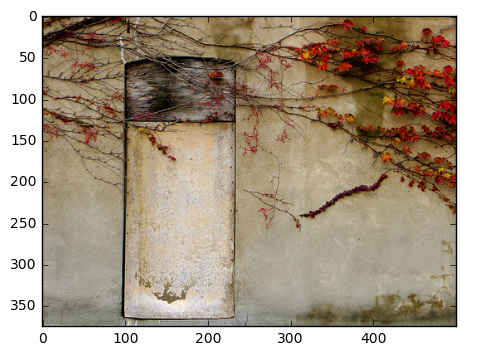

In [105]:
# test function listed before
run_test(IMAGEPATH,
    isProcess=False)